# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [6]:
print(env.observation_space)  # dealer's card value can be from [1, ..., 10, 11]
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [12]:
# for i_episode in range(3):
#     state = env.reset()
#     while True:
#         print(state)
#         action = env.action_space.sample()
#         state, reward, done, info = env.step(action)
#         if done:
#             print('End game! Reward: ', reward)
#             print('You won :)\n') if reward > 0 else print('You lost :(\n')
#             break
            
for i_episode in range(3):
    print('\nEpisode', i_episode)
    state = env.reset()
    while True:
        print('state', state)
        action = env.action_space.sample()
        print('action', action)        
        state, reward, done, info = env.step(action)
        print('next_state', state, ', reward', reward, ', done', done, ', info', info)                
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break            


Episode 0
state (20, 10, False)
action 0
next_state (20, 10, False) , reward 0.0 , done True , info {}
End game! Reward:  0.0
You lost :(


Episode 1
state (19, 6, False)
action 1
next_state (24, 6, False) , reward -1 , done True , info {}
End game! Reward:  -1
You lost :(


Episode 2
state (21, 1, True)
action 0
next_state (21, 1, True) , reward 1.0 , done True , info {}
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [15]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break            
    return episode


Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [21]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((16, 10, False), 1, -1)]
[((15, 3, False), 1, 0), ((16, 3, False), 1, -1)]
[((16, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [22]:
from collections import defaultdict
d = defaultdict(list)
s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
for k, v in s:
    d[k].append(v)
    
d

defaultdict(list, {'blue': [2, 4], 'red': [1], 'yellow': [1, 3]})

In [23]:
d.keys()

dict_keys(['yellow', 'blue', 'red'])

In [27]:
'yellow' in d

True

In [42]:
for k, v in d.items():
    print(k, v)

yellow [1, 3]
blue [2, 4]
red [1]


In [61]:
episode = [((16, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
states, actions, rewards = zip(*episode)
states, actions, rewards

(((16, 7, False), (21, 7, False)), (1, 0), (0, 1.0))

In [31]:
visited_states = set()
visited_states

set()

In [33]:
visited_states.add('a')
visited_states

{'a'}

In [55]:
visited_states.add('b')
visited_states

{'a', 'b'}

In [56]:
'a' in visited_states

True

In [37]:
for idx, (state, action, reward) in enumerate([((16, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]):
    print(idx, state, action, reward)

0 (16, 7, False) 1 0
1 (21, 7, False) 0 1.0


In [38]:
sum([1, 2])

3

In [74]:
episode = [((16, 7, False), 1, 0), ((21, 7, False), 0, 1.0), ((21, 7, False), 0, 2.0), ((21, 7, False), 0,3.0)]

In [80]:
[(r, 0.9**idx) for idx, (s,a,r) in enumerate(episode[2:])]

[(2.0, 1.0), (3.0, 0.9)]

In [78]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)  # [((16, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
        
        # First-visit
        visited_states = set()
        for idx, (state, action, reward) in enumerate(episode):
            if state not in visited_states:
                visited_states.add(state)                                     
                g = sum([(gamma**i) * r for i, (s, a, r) in enumerate(episode[idx:])])
                returns[state].append(g)
    
    V = dict()
    for state, state_returns in returns.items():
        V[state] = float(sum(state_returns)) / len(state_returns)        
        
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

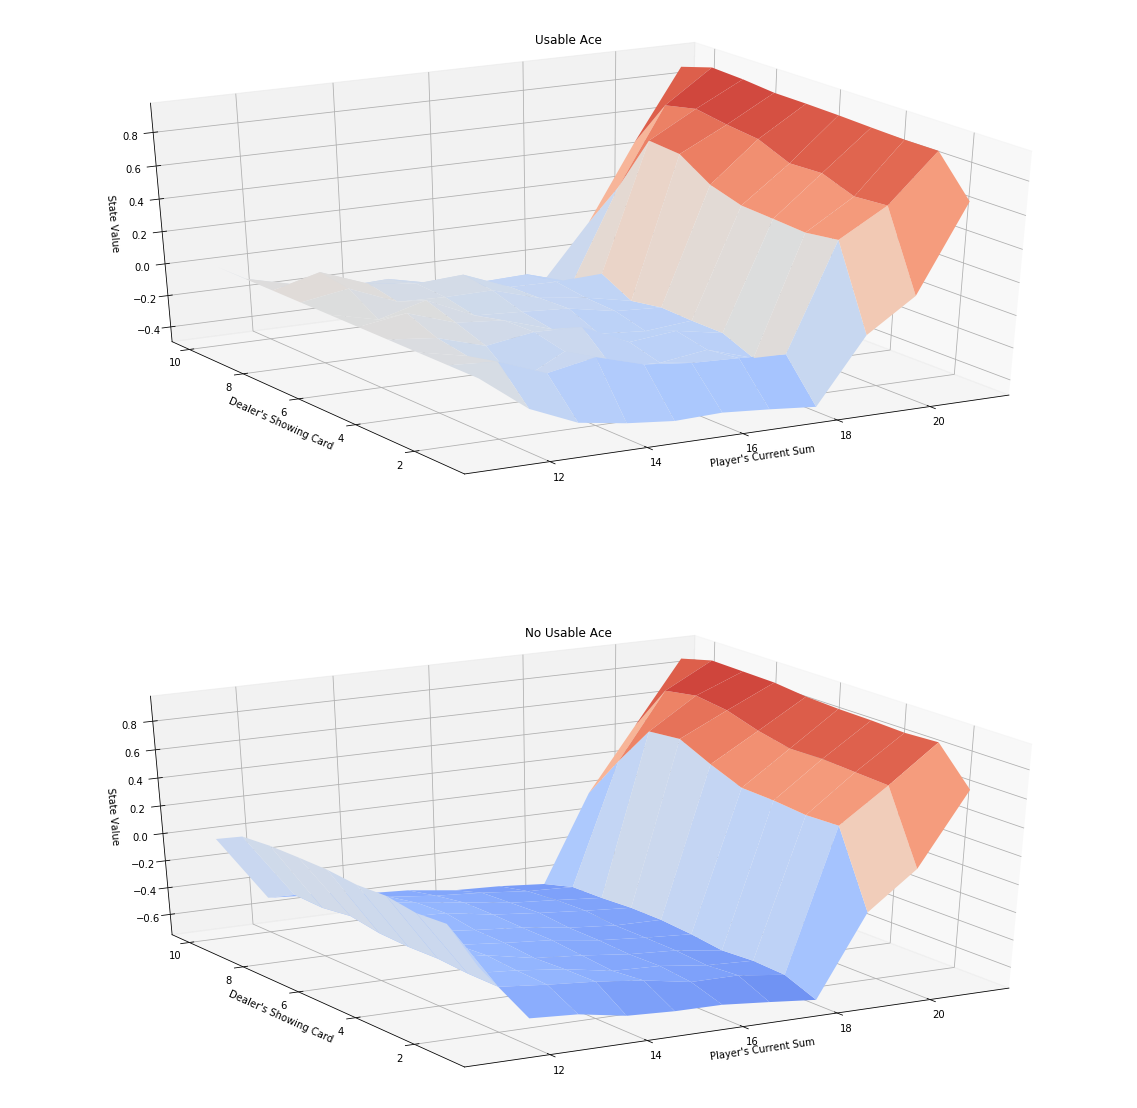

In [79]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

In [132]:
V

{(4, 1, False): -0.5446009389671361,
 (4, 2, False): -0.35377358490566035,
 (4, 3, False): -0.3483606557377049,
 (4, 4, False): -0.2850877192982456,
 (4, 5, False): -0.34418604651162793,
 (4, 6, False): -0.19069767441860466,
 (4, 7, False): -0.373134328358209,
 (4, 8, False): -0.2716049382716049,
 (4, 9, False): -0.2980769230769231,
 (4, 10, False): -0.4143947655398037,
 (5, 1, False): -0.5129411764705882,
 (5, 2, False): -0.3695150115473441,
 (5, 3, False): -0.2863961813842482,
 (5, 4, False): -0.32661290322580644,
 (5, 5, False): -0.2638580931263858,
 (5, 6, False): -0.28958333333333336,
 (5, 7, False): -0.29605263157894735,
 (5, 8, False): -0.36,
 (5, 9, False): -0.2962962962962963,
 (5, 10, False): -0.41899441340782123,
 (6, 1, False): -0.5049928673323824,
 (6, 2, False): -0.39162929745889385,
 (6, 3, False): -0.35636856368563685,
 (6, 4, False): -0.3562874251497006,
 (6, 5, False): -0.38427299703264095,
 (6, 6, False): -0.4093484419263456,
 (6, 7, False): -0.340941512125535,
 (6, 

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [81]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [84]:
env.action_space.n

2

In [86]:
a = set()
a.add((1,2))
a.add((1,1))
a

{(1, 1), (1, 2)}

In [89]:
(2,2) in a

False

In [96]:
a = np.array([[1, 2], [3, 4]])
a

array([[1, 2],
       [3, 4]])

In [98]:
a[:][0:1]

array([[1, 2]])

In [99]:
a[:, 0:1]

array([[1],
       [3]])

In [102]:
a[0:2, 0:1]

array([[1],
       [3]])

In [92]:
np.array([1, 2]) / np.array([2,2])

array([0.5, 1. ])

In [104]:
a = dict()
a = [{'k1': 'v1'}, {'k2': 'v2'}]
a

[{'k1': 'v1'}, {'k2': 'v2'}]

In [108]:
b = {i: i for i in range(3)}
b

{0: 0, 1: 1, 2: 2}

In [118]:
N = defaultdict(lambda: np.zeros(env.action_space.n))
N

defaultdict(<function __main__.<lambda>>, {})

In [119]:
N[0]

array([0., 0.])

In [120]:
N[0][0] += 1

In [133]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)

        # First-visit
        visited_state_action_set = set()
        for idx, (state, action, reward) in enumerate(episode):
            if (state, action) not in visited_state_action_set:
                visited_state_action_set.add((state, action))  
                g = sum([(gamma**i) * r for i, (s, a, r) in enumerate(episode[idx:])])                
                N[state][action] += 1
                returns_sum[state][action] += g
                                            
    Q = {state : (returns_sum[state] / N[state]) for state in returns_sum.keys()}        
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

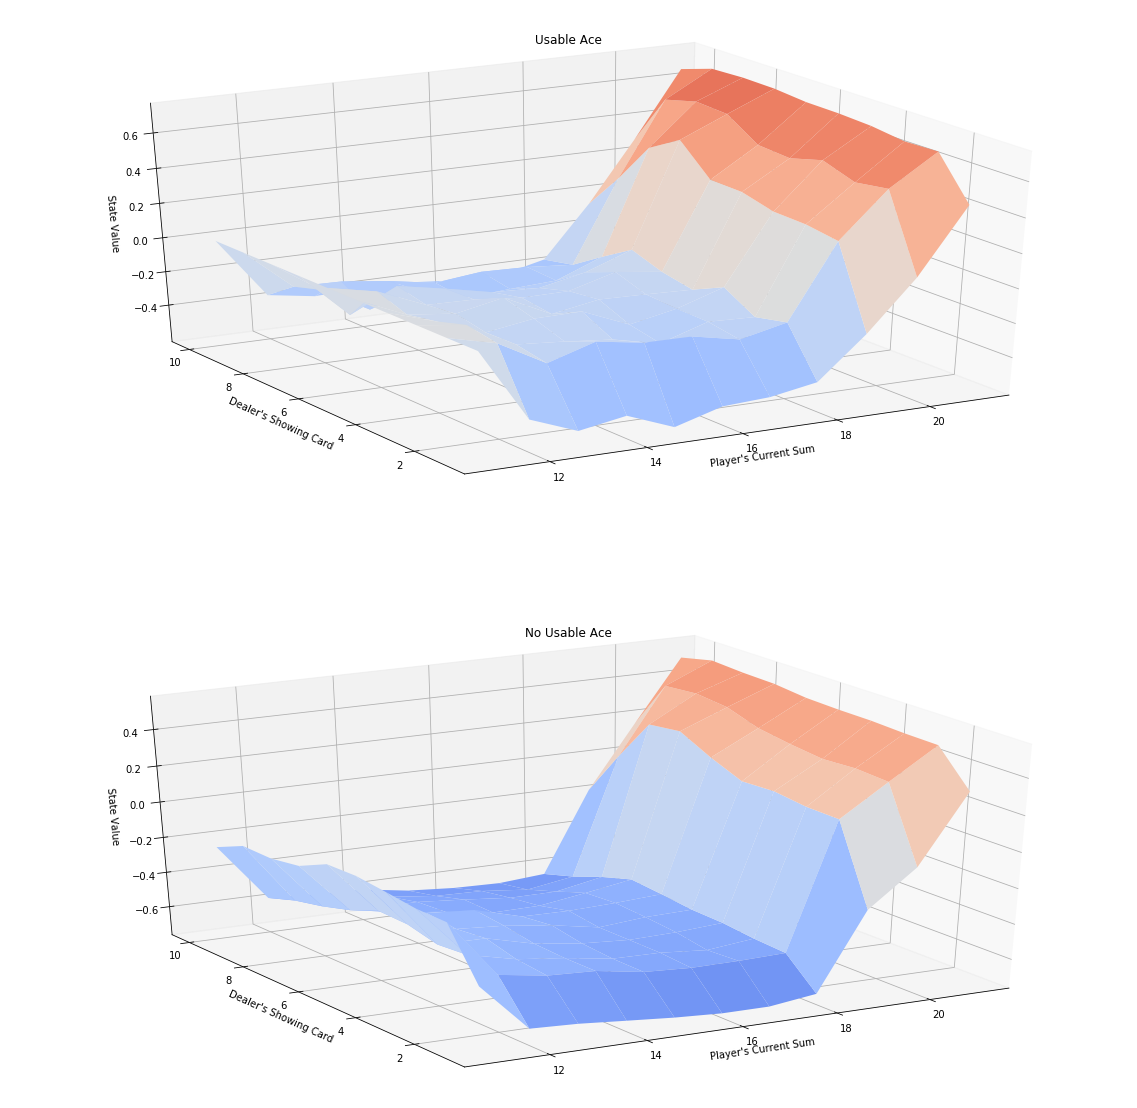

In [131]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict(
    (
        k, 
        (k[0]>18)*(np.dot([0.8, 0.2], v)) + (k[0]<=18)*(np.dot([0.2, 0.8], v))
    ) for k, v in Q.items()
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [127]:
Q

{(4, 1, False): array([-0.65517241, -0.67058824]),
 (4, 2, False): array([-0.25      , -0.36904762]),
 (4, 3, False): array([-0.125     , -0.32978723]),
 (4, 4, False): array([-0.28      , -0.32065217]),
 (4, 5, False): array([-0.30769231, -0.37234043]),
 (4, 6, False): array([-0.1627907 , -0.34054054]),
 (4, 7, False): array([-0.56097561, -0.43715847]),
 (4, 8, False): array([-0.79166667, -0.39053254]),
 (4, 9, False): array([-0.47368421, -0.49382716]),
 (4, 10, False): array([-0.62436548, -0.53485064]),
 (5, 1, False): array([-0.85858586, -0.75792507]),
 (5, 2, False): array([-0.15909091, -0.38655462]),
 (5, 3, False): array([-0.28205128, -0.39452055]),
 (5, 4, False): array([-0.13924051, -0.34031414]),
 (5, 5, False): array([ 0.02702703, -0.33795014]),
 (5, 6, False): array([-0.26315789, -0.45714286]),
 (5, 7, False): array([-0.5257732 , -0.42559524]),
 (5, 8, False): array([-0.52941176, -0.47790055]),
 (5, 9, False): array([-0.48837209, -0.49051491]),
 (5, 10, False): array([-0.592

In [126]:
V_to_plot

{(4, 1, False): -0.6675050709939149,
 (4, 2, False): -0.34523809523809523,
 (4, 3, False): -0.28882978723404257,
 (4, 4, False): -0.3125217391304348,
 (4, 5, False): -0.35941080196399344,
 (4, 6, False): -0.3049905719673162,
 (4, 7, False): -0.4619218979075037,
 (4, 8, False): -0.47075936883629194,
 (4, 9, False): -0.4897985705003249,
 (4, 10, False): -0.5527536085377389,
 (5, 1, False): -0.7780572293540593,
 (5, 2, False): -0.3410618792971734,
 (5, 3, False): -0.3720266947664208,
 (5, 4, False): -0.30009941016634634,
 (5, 5, False): -0.2649547053979187,
 (5, 6, False): -0.41834586466165413,
 (5, 7, False): -0.44563082965144823,
 (5, 8, False): -0.4882027949301268,
 (5, 9, False): -0.49008634272389234,
 (5, 10, False): -0.52211996471626,
 (6, 1, False): -0.6666331220019457,
 (6, 2, False): -0.43430388050663576,
 (6, 3, False): -0.4026444550647459,
 (6, 4, False): -0.3333615221987315,
 (6, 5, False): -0.30624846851261944,
 (6, 6, False): -0.37952380952380954,
 (6, 7, False): -0.44017923

### Part 3: MC Control: GLIE (Greedy in the Limit with Infinite Exploration)

In this section, you will write your own implementation of GLIE MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [175]:
def epsilon_greedy(env, Q, epsilon):
    # NOTE: set default action for unseen state
    total_num_actions = env.action_space.n
#     policy = defaultdict(lambda: np.random.choice(np.arange(total_num_actions)))
    policy = defaultdict(lambda: env.action_space.sample())    
    
    for state, action_values in Q.items():
        num_actions = len(action_values)        
        avg_action_prob = float(epsilon) / num_actions
        greedy_action_prob = 1 - epsilon + avg_action_prob                
        
        action_probs = avg_action_prob * np.ones(num_actions)
        
        max_action_idx = np.argmax(action_values)        
        action_probs[max_action_idx] = greedy_action_prob
        
        action = np.random.choice(np.arange(num_actions), p=action_probs)
        
        policy[state] = action
    
    return policy        

In [176]:
def generate_episode_GLIE(env, policy):    
    episode = []
    state = env.reset()
    while True:
        action = policy[state]
        # print('action', action)                
        next_state, reward, done, info = env.step(action)            
        episode.append((state, action, reward))            
        state = next_state
        if done:
            break
            
    return episode

In [177]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function  
        # Test 1: implemented by Solution
        epsilon = 1.0/((i_episode/8000)+1)
        # Test 2:
        # epsilon = 1.0 / i_episode

        policy = epsilon_greedy(env, Q, epsilon)
        
        episode = generate_episode_GLIE(env, policy)
        
        # First-visit
        visited_state_action_set = set()
        for idx, (state, action, reward) in enumerate(episode):
            if (state, action) not in visited_state_action_set:
                visited_state_action_set.add((state, action))  
                g = sum([(gamma**i) * r for i, (s, a, r) in enumerate(episode[idx:])])                
                N[state][action] += 1
                Q[state][action] += float(g - Q[state][action]) / N[state][action]                
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [178]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

### Test 1: epsilon = 1.0/((i_episode/8000)+1) returns good result

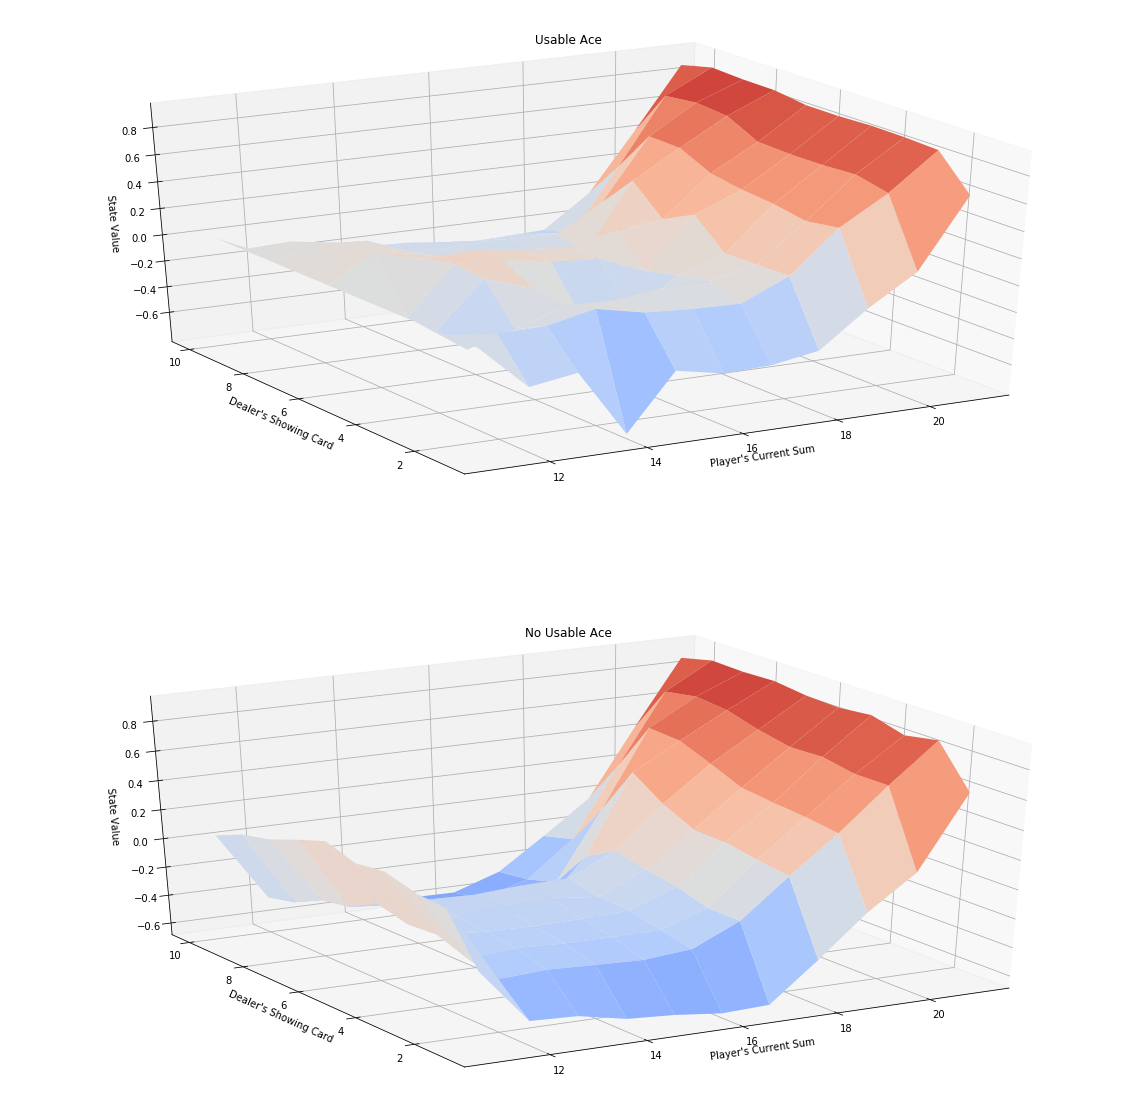

In [179]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

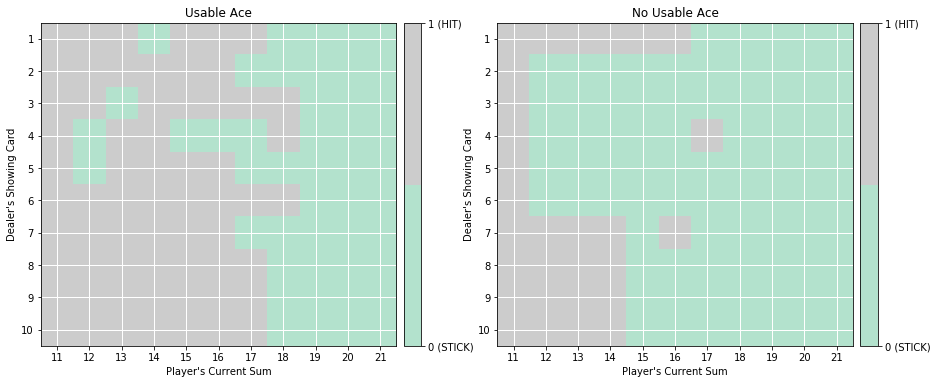

In [180]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

In [181]:
Q_glie

defaultdict(<function __main__.mc_control_GLIE.<locals>.<lambda>>,
            {(4, 1, False): array([-0.78378378, -0.46666667]),
             (4, 2, False): array([-0.25961538, -0.33333333]),
             (4, 3, False): array([-0.375     , -0.15819209]),
             (4, 4, False): array([-0.10810811, -0.01369863]),
             (4, 5, False): array([-0.0875576 , -0.53846154]),
             (4, 6, False): array([ 0.05426357, -0.06818182]),
             (4, 7, False): array([-0.6       , -0.20920502]),
             (4, 8, False): array([-0.47826087, -0.15508021]),
             (4, 9, False): array([-0.84615385, -0.23333333]),
             (4, 10, False): array([-0.55345912, -0.34130781]),
             (5, 1, False): array([-0.82608696, -0.57631579]),
             (5, 2, False): array([-0.27777778, -0.17974684]),
             (5, 3, False): array([-0.21588089, -0.47826087]),
             (5, 4, False): array([-0.11538462, -0.1025641 ]),
             (5, 5, False): array([-0.23287671,  0

In [182]:
V_glie

{(4, 1, False): -0.4666666666666666,
 (4, 2, False): -0.25961538461538464,
 (4, 3, False): -0.15819209039548024,
 (4, 4, False): -0.01369863013698629,
 (4, 5, False): -0.08755760368663598,
 (4, 6, False): 0.05426356589147287,
 (4, 7, False): -0.20920502092050206,
 (4, 8, False): -0.15508021390374338,
 (4, 9, False): -0.23333333333333334,
 (4, 10, False): -0.34130781499202567,
 (5, 1, False): -0.5763157894736847,
 (5, 2, False): -0.179746835443038,
 (5, 3, False): -0.21588089330024807,
 (5, 4, False): -0.10256410256410253,
 (5, 5, False): 0.05250000000000004,
 (5, 6, False): -0.036855036855036834,
 (5, 7, False): -0.2993039443155452,
 (5, 8, False): -0.20493827160493827,
 (5, 9, False): -0.5921052631578949,
 (5, 10, False): -0.3606370875995451,
 (6, 1, False): -0.4692653673163418,
 (6, 2, False): -0.27488855869242196,
 (6, 3, False): -0.10088495575221232,
 (6, 4, False): 0.015384615384615363,
 (6, 5, False): -0.10743801652892569,
 (6, 6, False): -0.0852359208523593,
 (6, 7, False): -0.1

In [183]:
policy_glie

defaultdict(<function __main__.epsilon_greedy.<locals>.<lambda>>,
            {(4, 1, False): 1,
             (4, 2, False): 0,
             (4, 3, False): 1,
             (4, 4, False): 1,
             (4, 5, False): 0,
             (4, 6, False): 0,
             (4, 7, False): 1,
             (4, 8, False): 1,
             (4, 9, False): 1,
             (4, 10, False): 1,
             (5, 1, False): 1,
             (5, 2, False): 1,
             (5, 3, False): 0,
             (5, 4, False): 1,
             (5, 5, False): 1,
             (5, 6, False): 1,
             (5, 7, False): 1,
             (5, 8, False): 1,
             (5, 9, False): 0,
             (5, 10, False): 1,
             (6, 1, False): 1,
             (6, 2, False): 0,
             (6, 3, False): 1,
             (6, 4, False): 1,
             (6, 5, False): 1,
             (6, 6, False): 1,
             (6, 7, False): 1,
             (6, 8, False): 1,
             (6, 9, False): 0,
             (6, 10, False): 1,
 

### Test 2: epsilon = 1.0/i_episode returns bad result

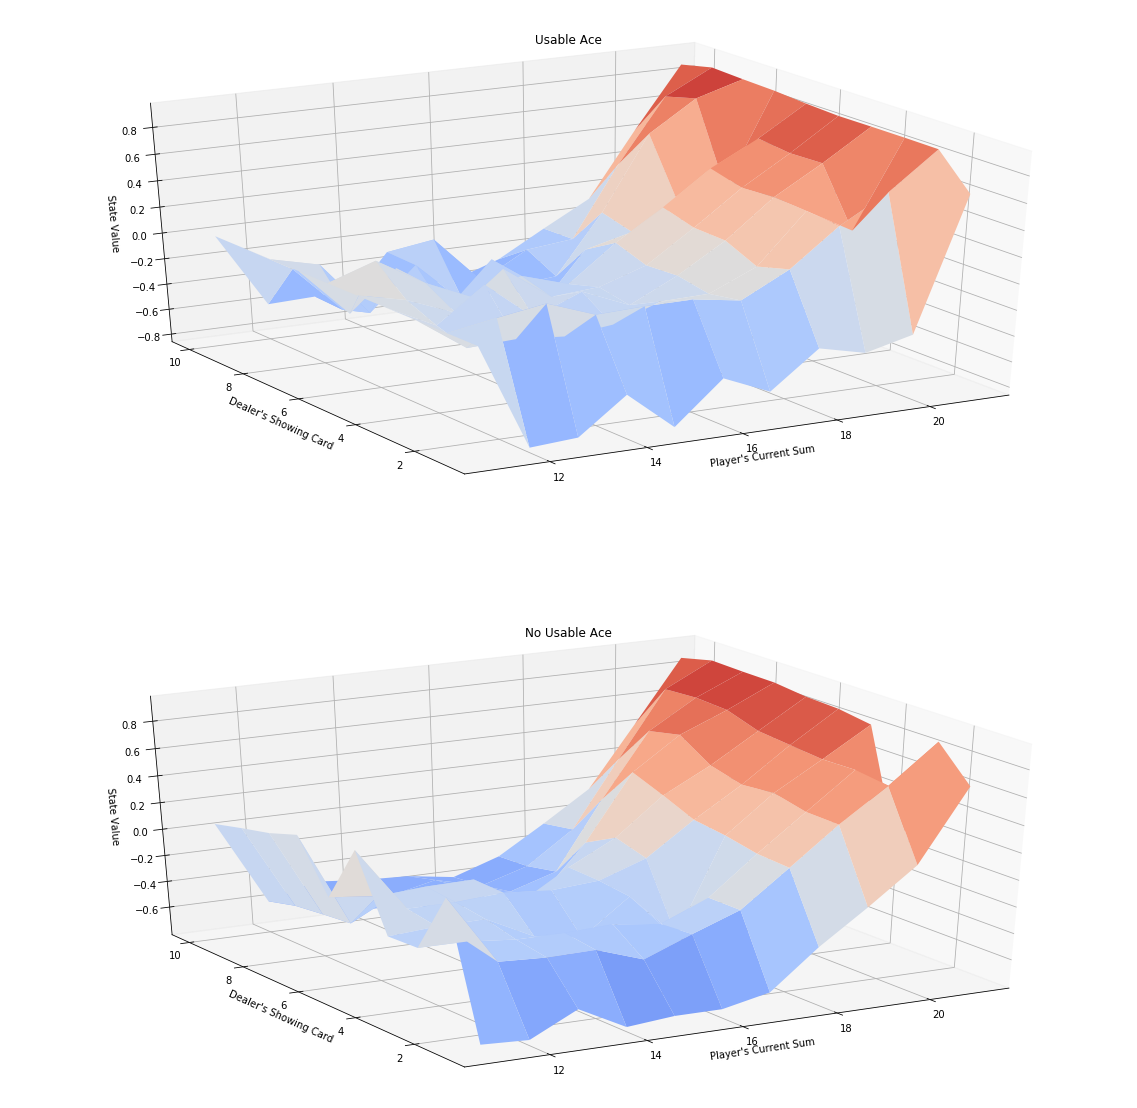

In [170]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

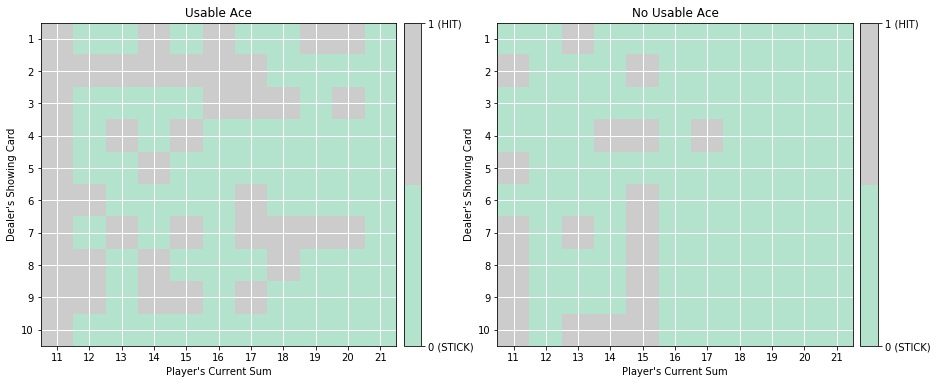

In [171]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

In [172]:
Q_glie

defaultdict(<function __main__.mc_control_GLIE.<locals>.<lambda>>,
            {(4, 1, False): array([-0.80869565, -1.        ]),
             (4, 2, False): array([-0.24786325, -1.        ]),
             (4, 3, False): array([-1.        , -0.13839286]),
             (4, 4, False): array([-0.23502304, -0.33333333]),
             (4, 5, False): array([-0.23076923, -0.10176991]),
             (4, 6, False): array([-0.27522936, -1.        ]),
             (4, 7, False): array([-0.36363636, -1.        ]),
             (4, 8, False): array([-0.55121951, -1.        ]),
             (4, 9, False): array([-0.51260504, -1.        ]),
             (4, 10, False): array([-0.58695652, -1.        ]),
             (5, 1, False): array([-0.77644711, -1.        ]),
             (5, 2, False): array([-1.        , -0.21868365]),
             (5, 3, False): array([-0.22823529, -1.        ]),
             (5, 4, False): array([-1.        , -0.27876106]),
             (5, 5, False): array([-0.0952381 , -0

In [173]:
V_glie

{(4, 1, False): -0.808695652173913,
 (4, 2, False): -0.24786324786324776,
 (4, 3, False): -0.13839285714285715,
 (4, 4, False): -0.23502304147465441,
 (4, 5, False): -0.10176991150442478,
 (4, 6, False): -0.27522935779816504,
 (4, 7, False): -0.36363636363636365,
 (4, 8, False): -0.5512195121951217,
 (4, 9, False): -0.512605042016807,
 (4, 10, False): -0.5869565217391302,
 (5, 1, False): -0.7764471057884231,
 (5, 2, False): -0.2186836518046709,
 (5, 3, False): -0.22823529411764706,
 (5, 4, False): -0.2787610619469026,
 (5, 5, False): -0.06728538283062638,
 (5, 6, False): -0.16417910447761191,
 (5, 7, False): -0.3864168618266979,
 (5, 8, False): -0.325531914893617,
 (5, 9, False): -0.41513292433537824,
 (5, 10, False): -0.5759955131800341,
 (6, 1, False): -0.7958620689655173,
 (6, 2, False): -0.2802275960170696,
 (6, 3, False): -0.2759643916913945,
 (6, 4, False): -0.17304747320061267,
 (6, 5, False): -0.14285714285714285,
 (6, 6, False): -0.16615384615384626,
 (6, 7, False): -0.2787610

In [174]:
policy_glie

defaultdict(<function __main__.epsilon_greedy.<locals>.<lambda>>,
            {(4, 1, False): 0,
             (4, 2, False): 0,
             (4, 3, False): 1,
             (4, 4, False): 0,
             (4, 5, False): 1,
             (4, 6, False): 0,
             (4, 7, False): 0,
             (4, 8, False): 0,
             (4, 9, False): 0,
             (4, 10, False): 0,
             (5, 1, False): 0,
             (5, 2, False): 1,
             (5, 3, False): 0,
             (5, 4, False): 1,
             (5, 5, False): 1,
             (5, 6, False): 0,
             (5, 7, False): 1,
             (5, 8, False): 1,
             (5, 9, False): 1,
             (5, 10, False): 0,
             (6, 1, False): 0,
             (6, 2, False): 0,
             (6, 3, False): 0,
             (6, 4, False): 0,
             (6, 5, False): 0,
             (6, 6, False): 0,
             (6, 7, False): 1,
             (6, 8, False): 1,
             (6, 9, False): 0,
             (6, 10, False): 0,
 

### Part 4: MC Control: Constant-$\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [184]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
#         epsilon = 1.0 / i_episode
        # Implemented in Solution:
        epsilon = 1.0/((i_episode/8000)+1)
 
        policy = epsilon_greedy(env, Q, epsilon)
        
        episode = generate_episode_GLIE(env, policy)
        
        # First-visit
        visited_state_action_set = set()
        for idx, (state, action, reward) in enumerate(episode):
            if (state, action) not in visited_state_action_set:
                visited_state_action_set.add((state, action))  
                g = sum([(gamma**i) * r for i, (s, a, r) in enumerate(episode[idx:])])                
                Q[state][action] += alpha * (g - Q[state][action])    
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [185]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

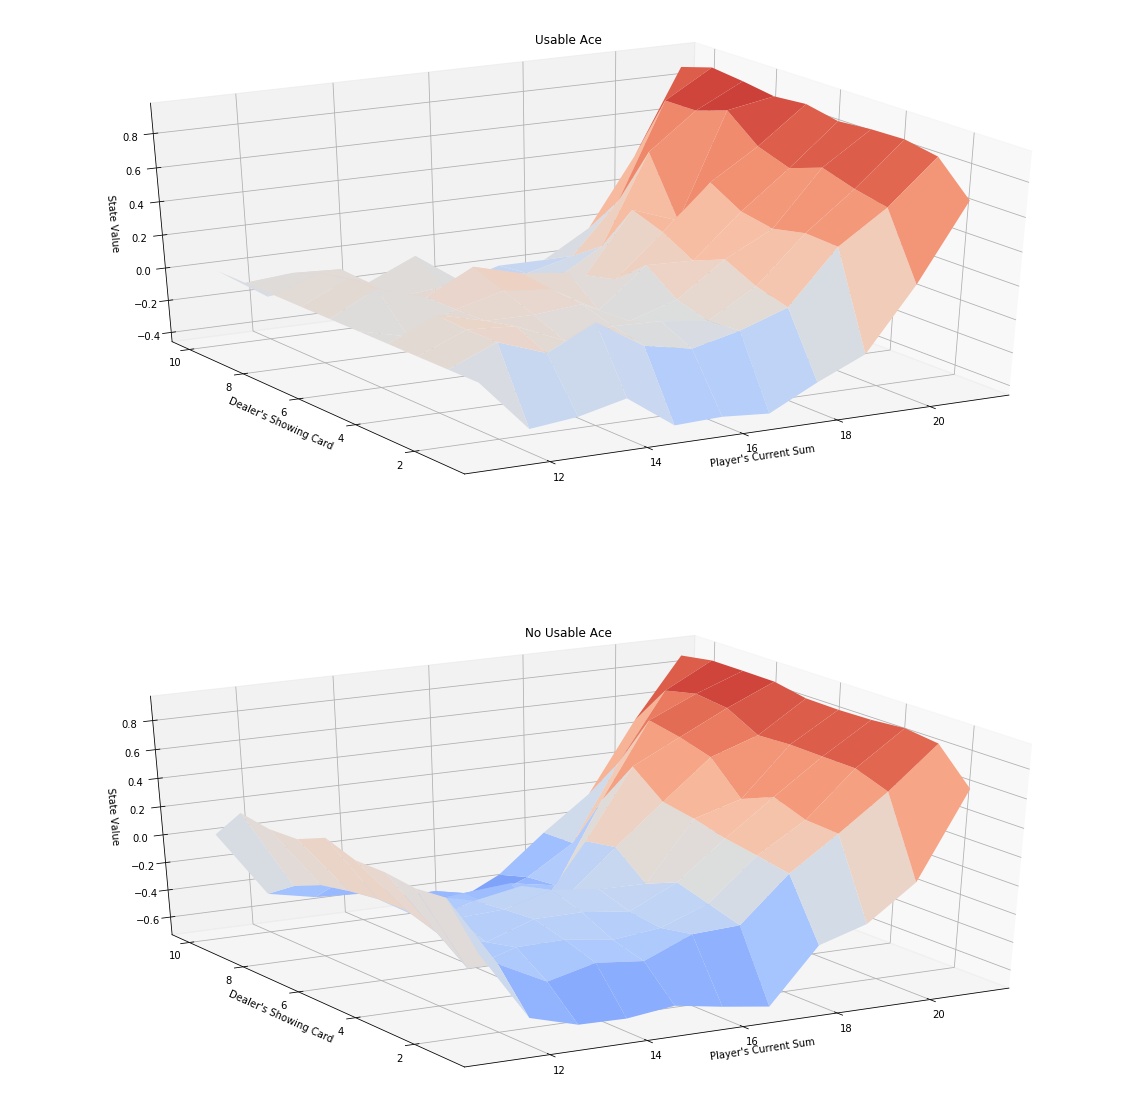

In [186]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

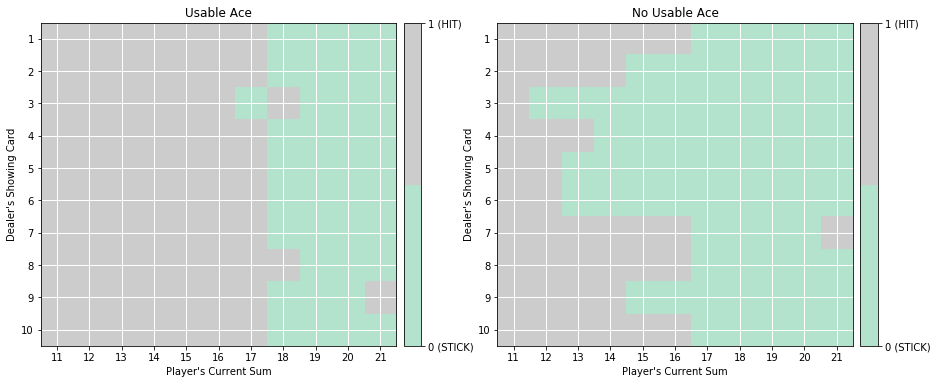

In [187]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)